In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = "lane_density_speed.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Define filtering parameters
TIME_LOWER_LIMIT = 1912.3  # Adjust as needed
TIME_UPPER_LIMIT = 5412.3  # Adjust as needed
INTERVAL = 300  # Interval for mean density calculations (seconds)
KM_TO_MI = 1.60934  # Conversion factor from km to miles

# Filter data based on time limits
filtered_df = df[(df["Time (s)"] >= TIME_LOWER_LIMIT) & (df["Time (s)"] <= TIME_UPPER_LIMIT)].copy()

# Extract unique edges from Detector ID (e.g., "E1_0_0m" → "0m", "E1_1_100m" → "100m")
filtered_df["Edge"] = filtered_df["Detector ID"].str.extract(r'(E1_\d+)_(\d+m)')[1]

# Adjust density to per lane density (since we have two lanes per segment)
filtered_df["Density (veh/km/lane)"] = filtered_df["Density (veh/km)"] / 2  # Adjusting for per lane

# Convert to veh/mi/l (vehicles per mile per lane)
filtered_df["Density (veh/mi/l)"] = filtered_df["Density (veh/km/lane)"] * KM_TO_MI  # Conversion

# Ensure the first interval starts at the first available timestamp
start_time = filtered_df["Time (s)"].min()
filtered_df["Interval"] = start_time + ((filtered_df["Time (s)"] - start_time) // INTERVAL) * INTERVAL

# Compute mean density per lane over 300s intervals
mean_density_df = (
    filtered_df
    .groupby(["Interval", "Edge", "Scenario"])["Density (veh/mi/l)"]
    .mean()
    .reset_index()
)

# Save to new CSV file
output_file = "mean_density_intervals.csv"
mean_density_df.to_csv(output_file, index=False)

print(f"Updated mean density data saved to {output_file}")

# Display final DataFrame
mean_density_df.head()


Updated mean density data saved to mean_density_intervals.csv


,Interval,Edge,Scenario,Density (veh/mi/l)
0,1913.1,0m,attack,12.137106
1,1913.1,0m,base,12.043228
2,1913.1,1000m,attack,19.392547
3,1913.1,1000m,base,19.030445
4,1913.1,100m,attack,12.391918


In [2]:
import pandas as pd

# Load the mean density dataset
mean_density_file = "mean_density_intervals.csv"  # Update with actual file path
df = pd.read_csv(mean_density_file)

# Define LOS classification function for urban freeway density
def classify_LOS(density):
    if density <= 11:
        return "A"
    elif 11 < density <= 18:
        return "B"
    elif 18 < density <= 26:
        return "C"
    elif 26 < density <= 35:
        return "D"
    elif 35 < density <= 45:
        return "E"
    else:
        return "F"

# Separate attack and base scenarios
attack_df = df[df["Scenario"] == "attack"].copy()
base_df = df[df["Scenario"] == "base"].copy()

# Assign LOS based on urban freeway density classification
attack_df["LOS"] = attack_df["Density (veh/mi/l)"].apply(classify_LOS)
base_df["LOS"] = base_df["Density (veh/mi/l)"].apply(classify_LOS)

# Round densities to the nearest whole number
attack_df["Density_attack"] = attack_df["Density (veh/mi/l)"].round(0)
base_df["Density_base"] = base_df["Density (veh/mi/l)"].round(0)

# Merge attack and base LOS & density data into a single DataFrame
los_df = attack_df[["Interval", "Edge", "LOS", "Density_attack"]].merge(
    base_df[["Interval", "Edge", "LOS", "Density_base"]],
    on=["Interval", "Edge"],
    suffixes=("_attack", "_base")
)

# Save to a new CSV file
los_output_file = "LOS_classification_with_density.csv"
los_df.to_csv(los_output_file, index=False)

print(f"LOS classification with densities saved to {los_output_file}")

# Display first few rows
los_df.head()


LOS classification with densities saved to LOS_classification_with_density.csv


,Interval,Edge,LOS_attack,Density_attack,LOS_base,Density_base
0,1913.1,0m,B,12.0,B,12.0
1,1913.1,1000m,C,19.0,C,19.0
2,1913.1,100m,B,12.0,B,12.0
3,1913.1,1100m,C,18.0,B,18.0
4,1913.1,1200m,B,17.0,B,17.0


/tmp/ipykernel_822697/4279244030.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_attack_numeric = los_attack_matrix.replace(los_mapping)
/tmp/ipykernel_822697/4279244030.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_base_numeric = los_base_matrix.replace(los_mapping)


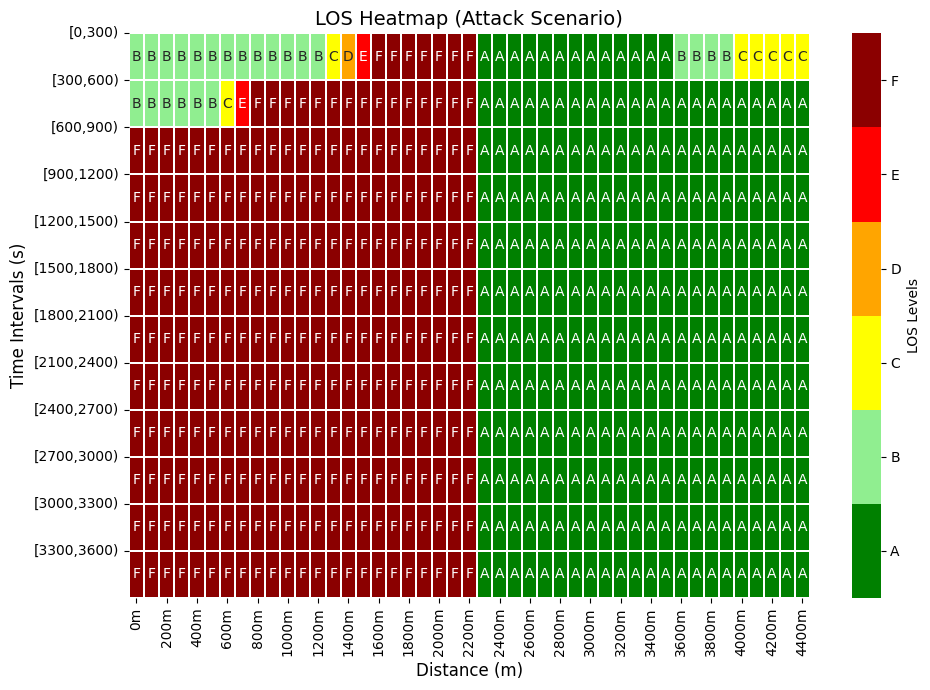

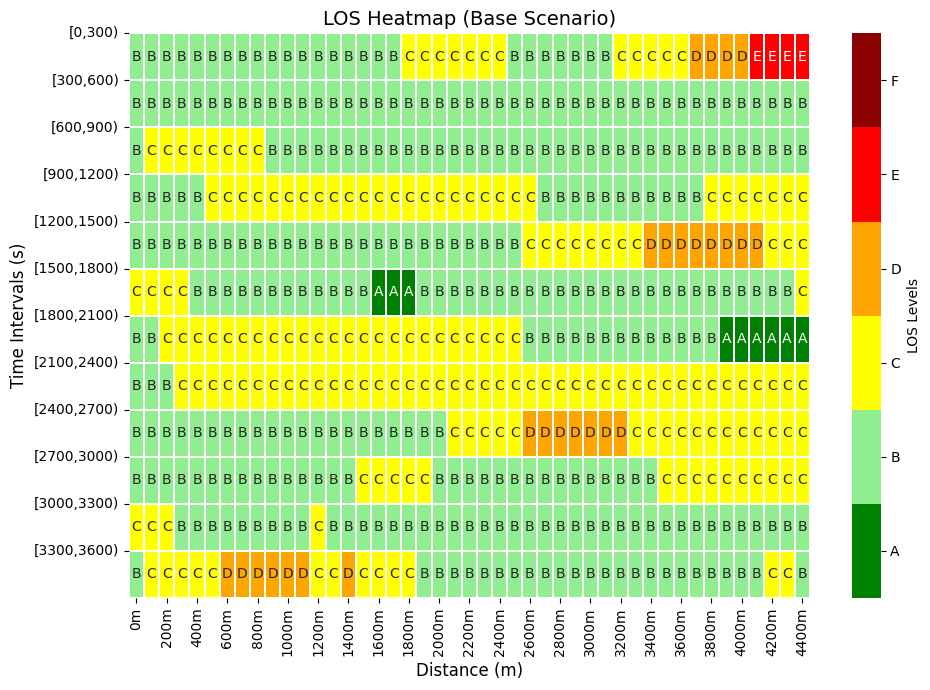

Heatmaps generated successfully!


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, ListedColormap

# Define the range for data to include in the heatmap
x_start = "0m"       # Start distance (inclusive)
x_end = "4400m"      # End distance (inclusive)
interval_step = 300   # Time step for grouping intervals

# Load the CSV file
file_path = "LOS_classification_with_density.csv" 
data = pd.read_csv(file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Define function to generate formatted time intervals
def format_time_intervals(times):
    intervals = []
    for t in times:
        start = int(t)
        end = start + interval_step
        intervals.append(f"[{start},{end})")
    return intervals

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Create pivot tables for LOS (Attack and Base)
los_attack_matrix = data.pivot(index="Time Group", columns="Edge", values="LOS_attack")
los_base_matrix = data.pivot(index="Time Group", columns="Edge", values="LOS_base")

# Filter columns (x-axis) by distance range
def filter_columns(matrix, x_start, x_end):
    numeric_start = int(x_start[:-1])
    numeric_end = int(x_end[:-1])
    sorted_columns = sorted(matrix.columns, key=lambda x: int(x[:-1]))  # Extract numeric part
    filtered_columns = [col for col in sorted_columns if numeric_start <= int(col[:-1]) <= numeric_end]
    return matrix[filtered_columns]

los_attack_matrix = filter_columns(los_attack_matrix, x_start, x_end)
los_base_matrix = filter_columns(los_base_matrix, x_start, x_end)

# Define LOS color mapping
los_colors = {
    "A": "green",
    "B": "lightgreen",
    "C": "yellow",
    "D": "orange",
    "E": "red",
    "F": "darkred"
}
los_cmap = ListedColormap([los_colors[k] for k in ["A", "B", "C", "D", "E", "F"]])
los_norm = Normalize(vmin=-0.5, vmax=5.5)  # Shift range to center ticks

# Convert LOS categories into numerical values for plotting
los_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
los_attack_numeric = los_attack_matrix.replace(los_mapping)
los_base_numeric = los_base_matrix.replace(los_mapping)

# Function to plot heatmap with formatted y-axis labels
def plot_los_heatmap(matrix, labels, title, output_file):
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(
        matrix,
        cmap=los_cmap,
        norm=los_norm,
        linewidths=0.01,
        linecolor="white",
        annot=labels,  # Annotate with actual LOS letters
        fmt="",
        cbar=True,
        cbar_kws={"label": "LOS Levels"},
    )

    # Set color bar ticks to be **centered**
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4, 5])  # Place ticks in the middle
    cbar.set_ticklabels(["A", "B", "C", "D", "E", "F"])  # Correct tick labels

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(0, len(matrix.index), 1)
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Prepare LOS labels for annotation
los_attack_labels = los_attack_matrix.copy()
los_base_labels = los_base_matrix.copy()

# Generate heatmaps
plot_los_heatmap(los_attack_numeric, los_attack_labels, "LOS Heatmap (Attack Scenario)", "LOS_Attack_Heatmap.pdf")
plot_los_heatmap(los_base_numeric, los_base_labels, "LOS Heatmap (Base Scenario)", "LOS_Base_Heatmap.pdf")

print("Heatmaps generated successfully!")


/tmp/ipykernel_822697/3153365528.py:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_attack_numeric = los_attack_matrix.replace(los_mapping)
/tmp/ipykernel_822697/3153365528.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_base_numeric = los_base_matrix.replace(los_mapping)


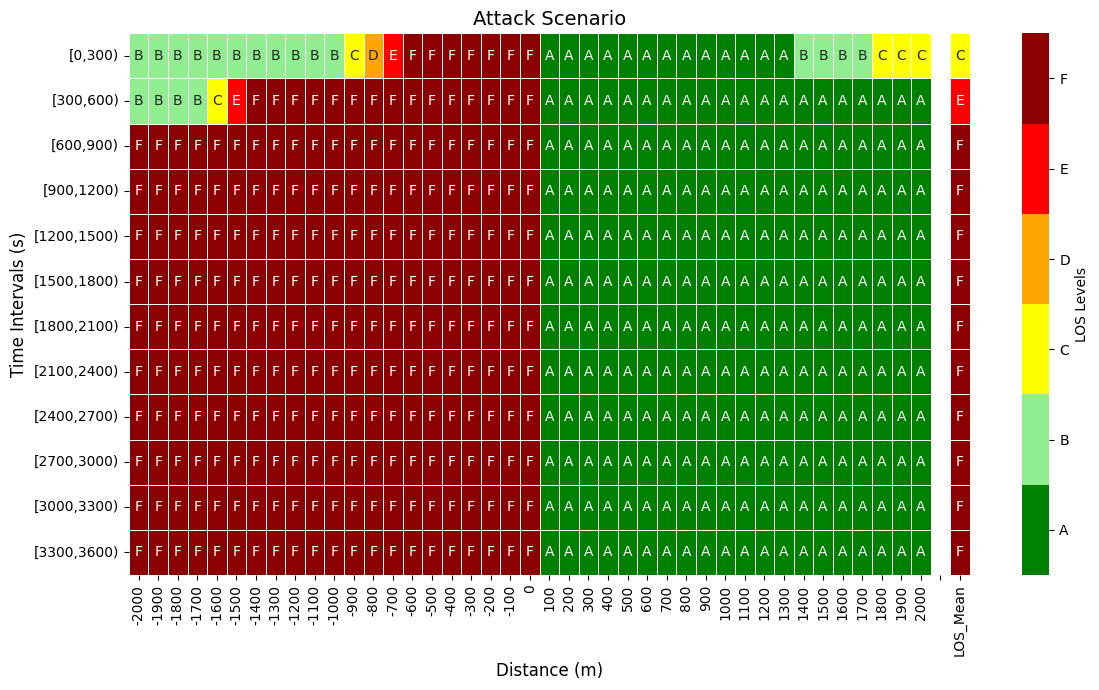

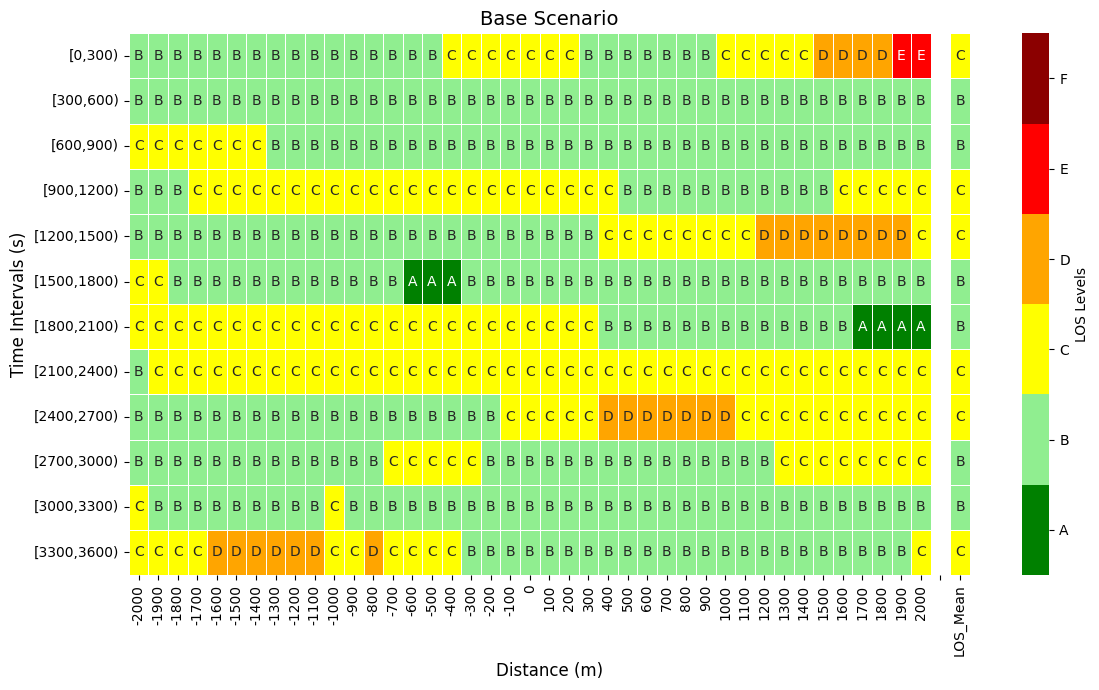

Heatmaps with highlighted LOS Mean column generated successfully!


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, ListedColormap

# Define the range for data to include in the heatmap
x_start = 200       # Start distance (inclusive) in meters
x_end = 4200      # End distance (inclusive) in meters
zero_point = 2200  # Set the reference zero point for the x-axis
interval_step = 300  # Time step for grouping intervals

# Load the CSV file
file_path = "LOS_classification_with_density.csv" 
data = pd.read_csv(file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Convert Edge values to numerical distance values
data["Edge"] = data["Edge"].str.replace("m", "").astype(int)

# Filter x-axis data (before applying zero reference point)
data = data[(data["Edge"] >= x_start) & (data["Edge"] <= x_end)]

# Adjust x-axis labels relative to the zero point
data["Adjusted Edge"] = data["Edge"] - zero_point

# Define LOS classification function based on density
def classify_LOS(density):
    if density <= 11:
        return "A"
    elif 11 < density <= 18:
        return "B"
    elif 18 < density <= 26:
        return "C"
    elif 26 < density <= 35:
        return "D"
    elif 35 < density <= 45:
        return "E"
    else:
        return "F"

# Compute mean density per time interval for both scenarios
mean_density_per_interval = data.groupby("Time Group")[["Density_attack", "Density_base"]].mean().reset_index()

# Compute LOS Mean for both attack and base scenarios
mean_density_per_interval["LOS_Mean_Attack"] = mean_density_per_interval["Density_attack"].apply(classify_LOS)
mean_density_per_interval["LOS_Mean_Base"] = mean_density_per_interval["Density_base"].apply(classify_LOS)

# Merge LOS Mean back into the dataset
data = data.merge(mean_density_per_interval[["Time Group", "LOS_Mean_Attack", "LOS_Mean_Base"]], on="Time Group", how="left")

# Create pivot tables for LOS (Attack and Base)
los_attack_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="LOS_attack")
los_base_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="LOS_base")

# Add a separator column (NaN values) before LOS_Mean for visual spacing
separator_column = " "  # Define separator column name
los_attack_matrix[separator_column] = np.nan  # Separator column
los_base_matrix[separator_column] = np.nan    # Separator column

# Add LOS Mean at the rightmost part of the table
los_attack_matrix["LOS_Mean"] = mean_density_per_interval.set_index("Time Group")["LOS_Mean_Attack"]
los_base_matrix["LOS_Mean"] = mean_density_per_interval.set_index("Time Group")["LOS_Mean_Base"]

# Define LOS color mapping
los_colors = {
    "A": "green",
    "B": "lightgreen",
    "C": "yellow",
    "D": "orange",
    "E": "red",
    "F": "darkred"
}
los_cmap = ListedColormap([los_colors[k] for k in ["A", "B", "C", "D", "E", "F"]])
los_norm = Normalize(vmin=-0.5, vmax=5.5)  # Shift range to center ticks

# Convert LOS categories into numerical values for plotting
los_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
los_attack_numeric = los_attack_matrix.replace(los_mapping)
los_base_numeric = los_base_matrix.replace(los_mapping)

# Function to format y-axis labels as time intervals
def format_time_intervals(times):
    return [f"[{int(t)},{int(t + interval_step)})" for t in times]

# Function to plot heatmap with adjusted x-axis labels and LOS Mean column
def plot_los_heatmap(matrix, labels, title, output_file):
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        matrix,
        cmap=los_cmap,
        norm=los_norm,
        linewidths=0.5,
        linecolor="white",
        annot=labels,  # Annotate with actual LOS letters
        fmt="",
        cbar=True,
        cbar_kws={"label": "LOS Levels"},
    )

    # Set color bar ticks to be **centered**
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4, 5])  # Place ticks in the middle
    cbar.set_ticklabels(["A", "B", "C", "D", "E", "F"])  # Correct tick labels

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(0.5, len(matrix.index), 1)
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    # Format x-axis labels with adjusted distances (removing separator column tick)
    x_tick_positions = np.arange(0.5, len(matrix.columns))
    x_tick_labels = matrix.columns.astype(str).tolist()
    
    # Remove tick label for separator column
    if separator_column in x_tick_labels:
        separator_index = x_tick_labels.index(separator_column)
        x_tick_labels[separator_index] = ""

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    # Highlight the LOS Mean column by changing its background color
    for text in ax.texts:
        if text.get_text() == "LOS_Mean":
            text.set_backgroundcolor("lightgrey")

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Prepare LOS labels for annotation
los_attack_labels = los_attack_matrix.copy()
los_base_labels = los_base_matrix.copy()

# Generate heatmaps
plot_los_heatmap(los_attack_numeric, los_attack_labels, "Attack Scenario", "LOS_Attack_Heatmap.pdf")
plot_los_heatmap(los_base_numeric, los_base_labels, "Base Scenario", "LOS_Base_Heatmap.pdf")

print("Heatmaps with highlighted LOS Mean column generated successfully!")


Updated LOS Mean values and TARA Impact Levels saved to 'LOS_with_mean.csv'.


/tmp/ipykernel_1393513/4029466530.py:118: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_attack_numeric = los_attack_matrix.replace(los_mapping)
/tmp/ipykernel_1393513/4029466530.py:119: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  los_base_numeric = los_base_matrix.replace(los_mapping)


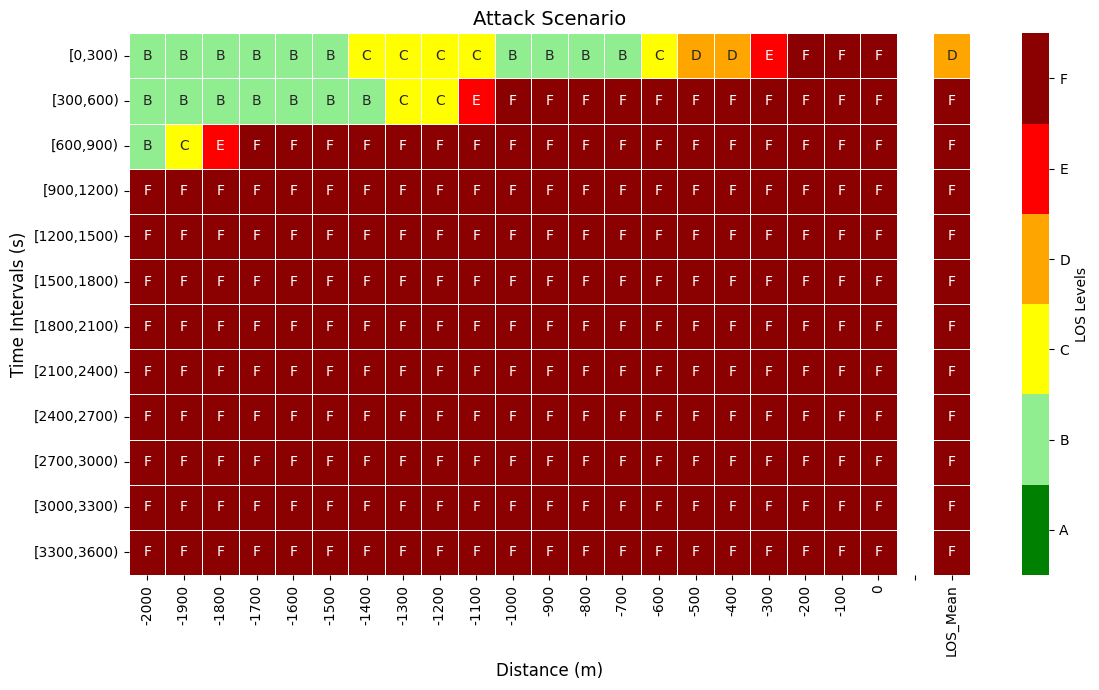

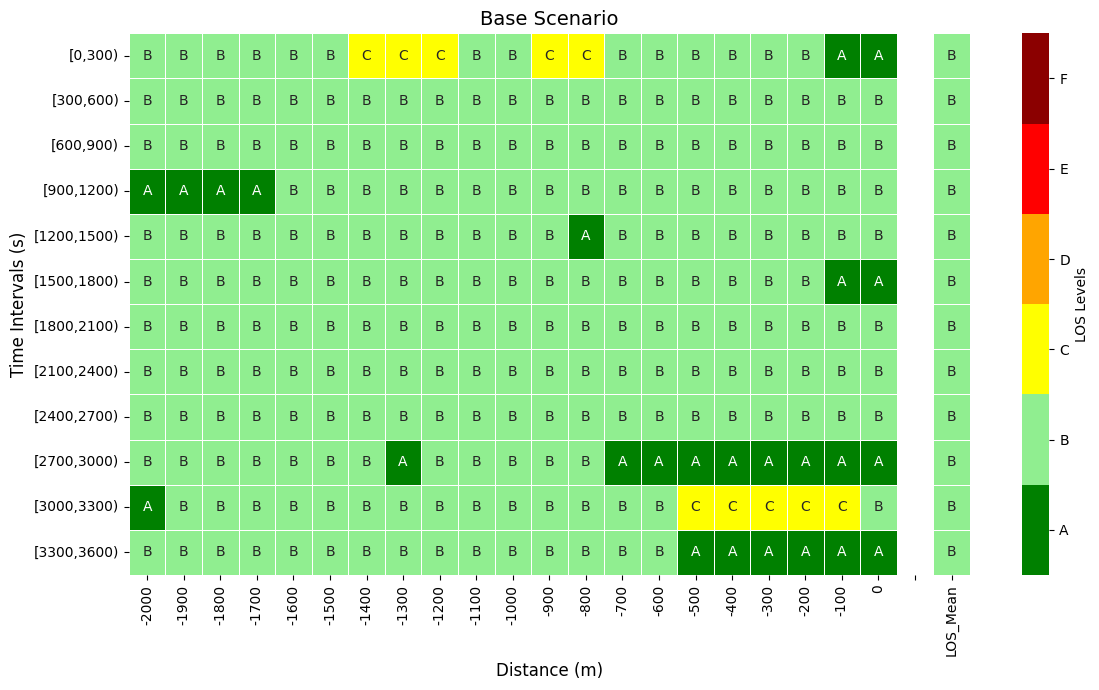

Heatmaps with highlighted LOS Mean column generated successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, ListedColormap

# Define the range for data to include in the heatmap
x_start = 200       # Start distance (inclusive) in meters
x_end = 2200        # End distance (inclusive) in meters
zero_point = 2200   # Set the reference zero point for the x-axis
interval_step = 300  # Time step for grouping intervals

# Load the CSV file
file_path = "LOS_classification_with_density.csv" 
data = pd.read_csv(file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Convert Edge values to numerical distance values
data["Edge"] = data["Edge"].str.replace("m", "").astype(int)

# Filter x-axis data (before applying zero reference point)
data = data[(data["Edge"] >= x_start) & (data["Edge"] <= x_end)]

# Adjust x-axis labels relative to the zero point
data["Adjusted Edge"] = data["Edge"] - zero_point

# Define LOS classification function based on density
def classify_LOS(density):
    if density <= 11:
        return "A"
    elif 11 < density <= 18:
        return "B"
    elif 18 < density <= 26:
        return "C"
    elif 26 < density <= 35:
        return "D"
    elif 35 < density <= 45:
        return "E"
    else:
        return "F"

# Compute mean density per time interval for both scenarios
mean_density_per_interval = data.groupby("Time Group")[["Density_attack", "Density_base"]].mean().reset_index()

# Compute LOS Mean for both attack and base scenarios
mean_density_per_interval["LOS_Mean_Attack"] = mean_density_per_interval["Density_attack"].apply(classify_LOS)
mean_density_per_interval["LOS_Mean_Base"] = mean_density_per_interval["Density_base"].apply(classify_LOS)

# Compute ΔLOS (Change in Level of Service)
mean_density_per_interval["LOS_change"] = mean_density_per_interval.apply(
    lambda row: ord(row["LOS_Mean_Attack"]) - ord(row["LOS_Mean_Base"]), axis=1
)

# **TARA Impact Classification**
def classify_tara_impact(row):
    delta_los = row["LOS_change"]
    los_attack = row["LOS_Mean_Attack"]

    if los_attack == "F":  # **Override: If LOS Attack is F, always Severe**
        return "Severe"
    elif delta_los == 0:
        return "Negligible"
    elif delta_los == 1:
        return "Moderate"
    elif delta_los in [2, 3]:
        return "Major"
    elif delta_los >= 4:
        return "Severe"
    elif delta_los < 0:
        return "ALI"
    return "Unknown"

# Apply classification to new column
mean_density_per_interval["TARA_Impact_Level"] = mean_density_per_interval.apply(classify_tara_impact, axis=1)

# Save updated data with LOS Mean and TARA Impact
mean_density_per_interval.to_csv("LOS_with_mean.csv", index=False)

print("Updated LOS Mean values and TARA Impact Levels saved to 'LOS_with_mean.csv'.")


# Merge LOS Mean back into the dataset
data = data.merge(mean_density_per_interval[["Time Group", "LOS_Mean_Attack", "LOS_Mean_Base"]], on="Time Group", how="left")

# Create pivot tables for LOS (Attack and Base)
los_attack_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="LOS_attack")
los_base_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="LOS_base")

# Add a separator column (NaN values) before LOS_Mean for visual spacing
separator_column = " "  # Define separator column name
los_attack_matrix[separator_column] = np.nan  # Separator column
los_base_matrix[separator_column] = np.nan    # Separator column

# Add LOS Mean at the rightmost part of the table
los_attack_matrix["LOS_Mean"] = mean_density_per_interval.set_index("Time Group")["LOS_Mean_Attack"]
los_base_matrix["LOS_Mean"] = mean_density_per_interval.set_index("Time Group")["LOS_Mean_Base"]

# Define LOS color mapping
los_colors = {
    "A": "green",
    "B": "lightgreen",
    "C": "yellow",
    "D": "orange",
    "E": "red",
    "F": "darkred"
}
los_cmap = ListedColormap([los_colors[k] for k in ["A", "B", "C", "D", "E", "F"]])
los_norm = Normalize(vmin=-0.5, vmax=5.5)  # Shift range to center ticks

# Convert LOS categories into numerical values for plotting
los_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
los_attack_numeric = los_attack_matrix.replace(los_mapping)
los_base_numeric = los_base_matrix.replace(los_mapping)

# Function to format y-axis labels as time intervals
def format_time_intervals(times):
    return [f"[{int(t)},{int(t + interval_step)})" for t in times]

# Function to plot heatmap with adjusted x-axis labels and LOS Mean column
def plot_los_heatmap(matrix, labels, title, output_file):
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        matrix,
        cmap=los_cmap,
        norm=los_norm,
        linewidths=0.5,
        linecolor="white",
        annot=labels,  # Annotate with actual LOS letters
        fmt="",
        cbar=True,
        cbar_kws={"label": "LOS Levels"},
    )

    # Set color bar ticks to be **centered**
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1, 2, 3, 4, 5])  # Place ticks in the middle
    cbar.set_ticklabels(["A", "B", "C", "D", "E", "F"])  # Correct tick labels

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(0.5, len(matrix.index), 1)
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    # Format x-axis labels with adjusted distances (removing separator column tick)
    x_tick_positions = np.arange(0.5, len(matrix.columns))
    x_tick_labels = matrix.columns.astype(str).tolist()
    
    # Remove tick label for separator column
    if separator_column in x_tick_labels:
        separator_index = x_tick_labels.index(separator_column)
        x_tick_labels[separator_index] = ""

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    # Highlight the LOS Mean column by changing its background color
    for text in ax.texts:
        if text.get_text() == "LOS_Mean":
            text.set_backgroundcolor("lightgrey")

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Prepare LOS labels for annotation
los_attack_labels = los_attack_matrix.copy()
los_base_labels = los_base_matrix.copy()

# Generate heatmaps
plot_los_heatmap(los_attack_numeric, los_attack_labels, "Attack Scenario", "LOS_Attack_Heatmap.pdf")
plot_los_heatmap(los_base_numeric, los_base_labels, "Base Scenario", "LOS_Base_Heatmap.pdf")

print("Heatmaps with highlighted LOS Mean column generated successfully!")


In [4]:
import pandas as pd

# Load the CSV file
file_path = "LOS_classification_with_density.csv"
data = pd.read_csv(file_path)

# Define LOS mapping
los_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
inverse_los_mapping = {v: k for k, v in los_mapping.items()}

# Convert LOS levels to numeric values
data["LOS_base_numeric"] = data["LOS_base"].map(los_mapping)
data["LOS_attack_numeric"] = data["LOS_attack"].map(los_mapping)

# Compute LOS Change (ΔLOS)
data["LOS_change"] = data["LOS_attack_numeric"] - data["LOS_base_numeric"]

# Identify Artificial LOS Improvement (ALI)
data["ALI_Flag"] = data["LOS_change"] < 0  # True if LOS improved artificially

# Define function for TARA classification
def classify_tara(base_los, attack_los, delta_los, ali_flag):
    if ali_flag:
        return "Artificial LOS Improvement (ALI)"
    elif delta_los == 0:
        return "Negligible"
    elif attack_los == 5:  # LOS-F scenario (traffic breakdown)
        return "Severe"
    elif delta_los == 1:
        return "Moderate"
    elif delta_los in [2, 3]:
        return "Major"
    elif delta_los >= 4:
        return "Severe"
    else:
        return "Unknown"

# Apply TARA classification with ALI handling
data["TARA_Impact"] = data.apply(
    lambda row: classify_tara(row["LOS_base_numeric"], row["LOS_attack_numeric"], row["LOS_change"], row["ALI_Flag"]),
    axis=1
)

# Convert LOS Change back to letter format
data["LOS_change"] = data["LOS_change"].apply(lambda x: f"{'+' if x > 0 else ''}{x}")

# Drop temporary numeric columns
data.drop(columns=["LOS_base_numeric", "LOS_attack_numeric"], inplace=True)

# Save updated dataset
output_file = "LOS_with_TARA_classification_and_ALI.csv"
data.to_csv(output_file, index=False)

print(f"Updated CSV saved as {output_file}")


Updated CSV saved as LOS_with_TARA_classification_and_ALI.csv


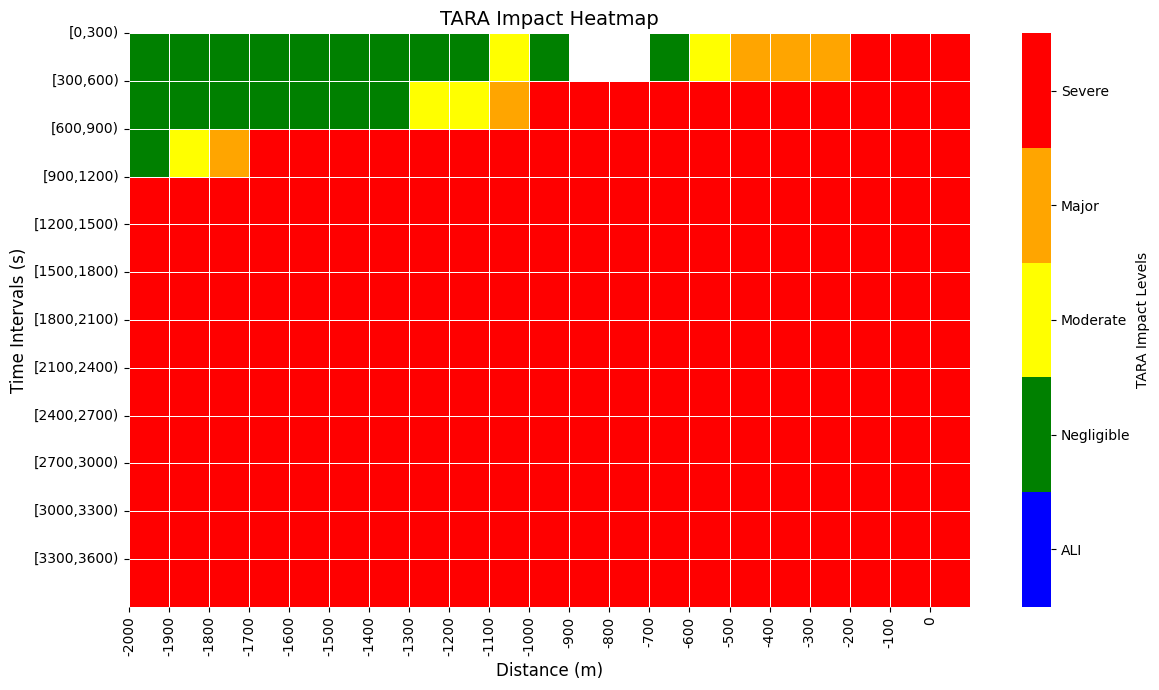

TARA Impact Heatmap generated successfully!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

# Define the range for data to include in the heatmap
x_start = 200       # Start distance (inclusive) in meters
x_end = 2200        # End distance (inclusive) in meters
zero_point = 2200   # Set the reference zero point for the x-axis
interval_step = 300  # Time step for grouping intervals

# Load the CSV file
file_path = "LOS_with_TARA_classification_and_ALI.csv" 
data = pd.read_csv(file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Convert Edge values to numerical distance values
data["Edge"] = data["Edge"].str.replace("m", "").astype(int)

# Filter x-axis data (before applying zero reference point)
data = data[(data["Edge"] >= x_start) & (data["Edge"] <= x_end)]

# Adjust x-axis labels relative to the zero point
data["Adjusted Edge"] = data["Edge"] - zero_point

# Define TARA color mapping
tara_colors = {
    "ALI": "blue",
    "Negligible": "green",
    "Moderate": "yellow",
    "Major": "orange",
    "Severe": "red",
}
tara_cmap = ListedColormap([tara_colors[k] for k in tara_colors])
tara_levels = list(tara_colors.keys())
tara_norm = Normalize(vmin=-0.5, vmax=4.5)

# Convert TARA impact to numeric for plotting
tara_mapping = {label: i for i, label in enumerate(tara_levels)}
inverse_tara_mapping = {v: k for k, v in tara_mapping.items()}
data["TARA_numeric"] = data["TARA_Impact"].map(tara_mapping)

# Pivot the table for heatmap plotting (TARA Impact per road segment)
tara_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="TARA_numeric")

# **Function to format y-axis labels as time intervals**
def format_time_intervals(times):
    return [f"[{int(t)},{int(t + interval_step)})" for t in times]

# **Function to plot heatmap**
def plot_tara_heatmap(matrix, labels, title, output_file):
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        matrix,
        cmap=tara_cmap,
        norm=tara_norm,
        linewidths=0.5,
        linecolor="white",
        # annot=labels,  # Annotate with TARA impact labels
        fmt="",
        cbar=True,
        cbar_kws={"label": "TARA Impact Levels"},
    )

    # Customize color bar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(range(len(tara_levels)))  
    cbar.set_ticklabels(tara_levels)

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(len(matrix.index))
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    # Format x-axis labels with adjusted distances
    x_tick_positions = np.arange(len(matrix.columns))
    x_tick_labels = matrix.columns.astype(str).tolist()
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Prepare labels for annotation
tara_labels = tara_matrix.copy()
tara_labels.replace(inverse_tara_mapping, inplace=True)

# Generate heatmap for TARA Impact
plot_tara_heatmap(tara_matrix, tara_labels, "TARA Impact Heatmap", "TARA_Impact_Heatmap.pdf")

print("TARA Impact Heatmap generated successfully!")


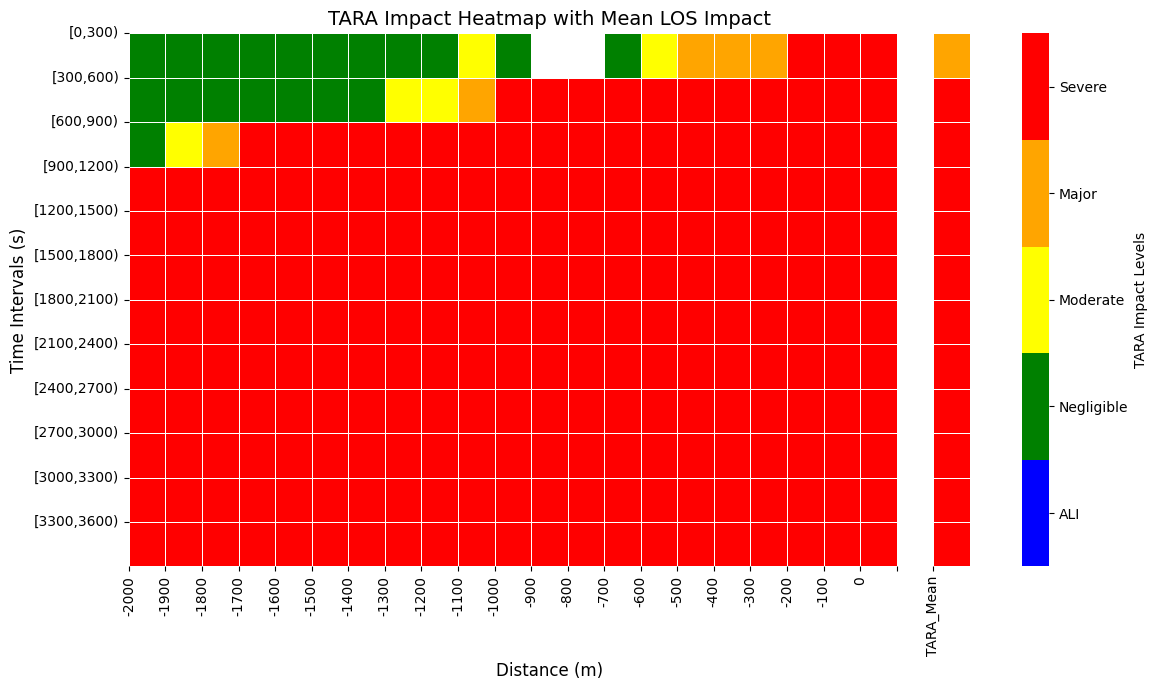

In [6]:
# Re-import required libraries after execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

# Define the range for data to include in the heatmap
x_start = 200       # Start distance (inclusive) in meters
x_end = 2200        # End distance (inclusive) in meters
zero_point = 2200   # Set the reference zero point for the x-axis
interval_step = 300  # Time step for grouping intervals

# Reload the CSV files
tara_file_path = "LOS_with_TARA_classification_and_ALI.csv"
mean_los_file_path = "LOS_with_mean.csv"

data = pd.read_csv(tara_file_path)
mean_los_data = pd.read_csv(mean_los_file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Convert Edge values to numerical distance values
data["Edge"] = data["Edge"].str.replace("m", "").astype(int)

# Filter x-axis data (before applying zero reference point)
data = data[(data["Edge"] >= x_start) & (data["Edge"] <= x_end)]

# Adjust x-axis labels relative to the zero point
data["Adjusted Edge"] = data["Edge"] - zero_point

# Define TARA color mapping
tara_colors = {
    "ALI": "blue",
    "Negligible": "green",
    "Moderate": "yellow",
    "Major": "orange",
    "Severe": "red",
}
tara_cmap = ListedColormap([tara_colors[k] for k in tara_colors])
tara_levels = list(tara_colors.keys())
tara_norm = Normalize(vmin=-0.5, vmax=4.5)

# Convert TARA impact to numeric for plotting
tara_mapping = {label: i for i, label in enumerate(tara_levels)}
inverse_tara_mapping = {v: k for k, v in tara_mapping.items()}
data["TARA_numeric"] = data["TARA_Impact"].map(tara_mapping)

# Pivot the table for heatmap plotting (TARA Impact per road segment)
tara_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="TARA_numeric")

# Compute mean LOS change per time interval
mean_los_data["LOS_change"] = mean_los_data.apply(
    lambda row: ord(row["LOS_Mean_Attack"]) - ord(row["LOS_Mean_Base"]), axis=1
)

# Map mean LOS change to TARA impact using the same classification
def map_tara_impact(delta_los):
    if delta_los == 0:
        return "Negligible"
    elif delta_los == 1:
        return "Moderate"
    elif delta_los in [2, 3]:
        return "Major"
    elif delta_los >= 4:
        return "Severe"
    elif delta_los < 0:
        return "ALI"
    return "Unknown"

mean_los_data["TARA_Mean_Impact"] = mean_los_data["LOS_change"].apply(map_tara_impact)
mean_los_data["TARA_Mean_numeric"] = mean_los_data["TARA_Mean_Impact"].map(tara_mapping)

# Add a separator column before TARA_Mean for visual spacing
tara_matrix[" "] = np.nan
tara_matrix["TARA_Mean"] = mean_los_data.set_index("Time Group")["TARA_Mean_numeric"]

# Function to format y-axis labels as time intervals
def format_time_intervals(times):
    return [f"[{int(t)},{int(t + interval_step)})" for t in times]

# Function to plot heatmap
def plot_tara_heatmap(matrix, title, output_file):
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        matrix,
        cmap=tara_cmap,
        norm=tara_norm,
        linewidths=0.5,
        linecolor="white",
        cbar=True,
        cbar_kws={"label": "TARA Impact Levels"},
    )

    # Customize color bar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(range(len(tara_levels)))
    cbar.set_ticklabels(tara_levels)

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(len(matrix.index))
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    # Format x-axis labels with adjusted distances
    x_tick_positions = np.arange(len(matrix.columns))
    x_tick_labels = matrix.columns.astype(str).tolist()

    # Remove tick label for separator column
    if " " in x_tick_labels:
        separator_index = x_tick_labels.index(" ")
        x_tick_labels[separator_index] = ""

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Generate heatmap for TARA Impact including mean LOS impact
plot_tara_heatmap(tara_matrix, "TARA Impact Heatmap with Mean LOS Impact", "TARA_Impact_Heatmap.pdf")


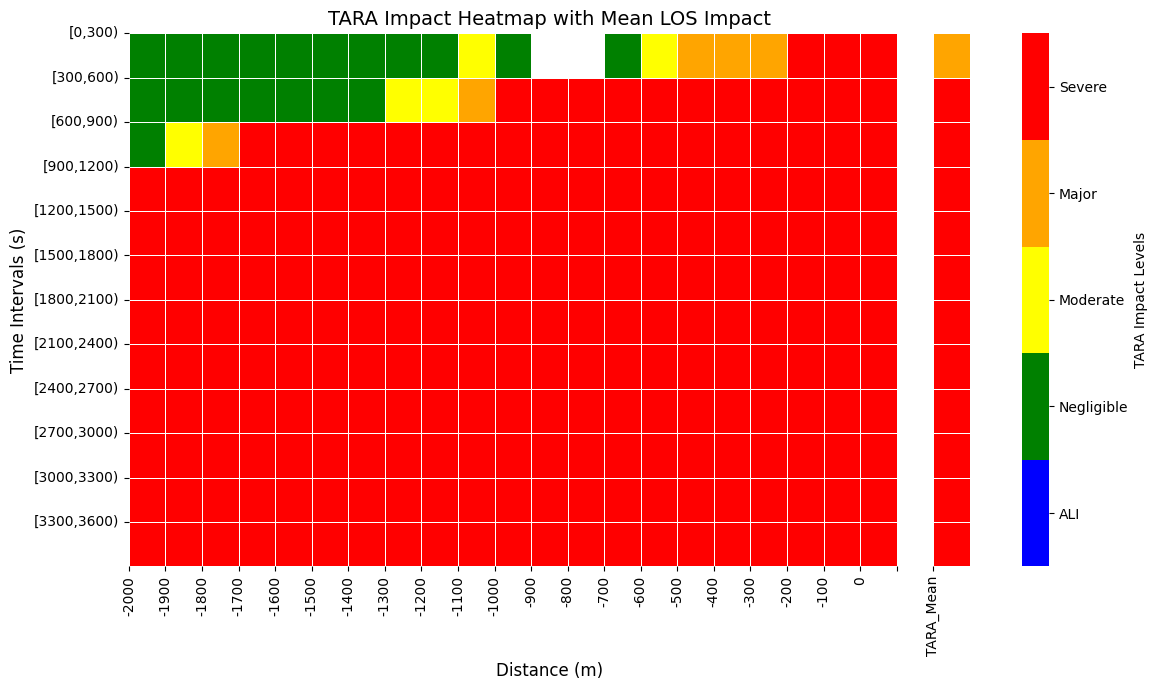

TARA Impact Heatmap generated successfully!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

# Define the range for data to include in the heatmap
x_start = 200       # Start distance (inclusive) in meters
x_end = 2200        # End distance (inclusive) in meters
zero_point = 2200   # Set the reference zero point for the x-axis
interval_step = 300  # Time step for grouping intervals

# Reload the CSV files
tara_file_path = "LOS_with_TARA_classification_and_ALI.csv"
mean_los_file_path = "LOS_with_mean.csv"

data = pd.read_csv(tara_file_path)
mean_los_data = pd.read_csv(mean_los_file_path)

# Adjust time values so the smallest becomes 0
min_time = data["Interval"].min()
data["adjusted_time"] = data["Interval"] - min_time

# Assign interval groups
data["Time Group"] = (data["adjusted_time"] // interval_step) * interval_step

# Convert Edge values to numerical distance values
data["Edge"] = data["Edge"].str.replace("m", "").astype(int)

# Filter x-axis data (before applying zero reference point)
data = data[(data["Edge"] >= x_start) & (data["Edge"] <= x_end)]

# Adjust x-axis labels relative to the zero point
data["Adjusted Edge"] = data["Edge"] - zero_point

# Define TARA color mapping
tara_colors = {
    "ALI": "blue",
    "Negligible": "green",
    "Moderate": "yellow",
    "Major": "orange",
    "Severe": "red",
}
tara_cmap = ListedColormap([tara_colors[k] for k in tara_colors])
tara_levels = list(tara_colors.keys())
tara_norm = Normalize(vmin=-0.5, vmax=4.5)

# Convert TARA impact to numeric for plotting
tara_mapping = {label: i for i, label in enumerate(tara_levels)}
inverse_tara_mapping = {v: k for k, v in tara_mapping.items()}
data["TARA_numeric"] = data["TARA_Impact"].map(tara_mapping)

# Pivot the table for heatmap plotting (TARA Impact per road segment)
tara_matrix = data.pivot(index="Time Group", columns="Adjusted Edge", values="TARA_numeric")

# Compute mean LOS change per time interval
mean_los_data["LOS_change"] = mean_los_data.apply(
    lambda row: ord(row["LOS_Mean_Attack"]) - ord(row["LOS_Mean_Base"]), axis=1
)

# **Updated Function to Map TARA Impact (Including LOS=F Override)**
def map_tara_impact(row):
    delta_los = row["LOS_change"]
    los_attack = row["LOS_Mean_Attack"]

    if los_attack == "F":  # Override: If LOS Attack is F, impact is always SEVERE
        return "Severe"
    elif delta_los == 0:
        return "Negligible"
    elif delta_los == 1:
        return "Moderate"
    elif delta_los in [2, 3]:
        return "Major"
    elif delta_los >= 4:
        return "Severe"
    elif delta_los < 0:
        return "ALI"
    return "Unknown"

# Apply TARA mapping function
mean_los_data["TARA_Mean_Impact"] = mean_los_data.apply(map_tara_impact, axis=1)
mean_los_data["TARA_Mean_numeric"] = mean_los_data["TARA_Mean_Impact"].map(tara_mapping)

# Add a separator column before TARA_Mean for visual spacing
tara_matrix[" "] = np.nan
tara_matrix["TARA_Mean"] = mean_los_data.set_index("Time Group")["TARA_Mean_numeric"]

# **Function to format y-axis labels as time intervals**
def format_time_intervals(times):
    return [f"[{int(t)},{int(t + interval_step)})" for t in times]

# **Function to plot heatmap**
def plot_tara_heatmap(matrix, title, output_file):
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(
        matrix,
        cmap=tara_cmap,
        norm=tara_norm,
        linewidths=0.5,
        linecolor="white",
        cbar=True,
        cbar_kws={"label": "TARA Impact Levels"},
    )

    # Customize color bar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(range(len(tara_levels)))
    cbar.set_ticklabels(tara_levels)

    # Format y-axis labels as time intervals
    y_tick_positions = np.arange(len(matrix.index))
    y_tick_labels = format_time_intervals(matrix.index)
    ax.set_yticks(y_tick_positions)
    ax.set_yticklabels(y_tick_labels, rotation=0)

    # Format x-axis labels with adjusted distances
    x_tick_positions = np.arange(len(matrix.columns))
    x_tick_labels = matrix.columns.astype(str).tolist()

    # Remove tick label for separator column
    if " " in x_tick_labels:
        separator_index = x_tick_labels.index(" ")
        x_tick_labels[separator_index] = ""

    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=90)

    plt.xlabel("Distance (m)", fontsize=12)
    plt.ylabel("Time Intervals (s)", fontsize=12)
    plt.title(title, fontsize=14)

    plt.tight_layout()
    plt.savefig(output_file, format='pdf', dpi=300)
    plt.show()

# Generate heatmap for TARA Impact including mean LOS impact
plot_tara_heatmap(tara_matrix, "TARA Impact Heatmap with Mean LOS Impact", "TARA_Impact_Heatmap.pdf")

print("TARA Impact Heatmap generated successfully!")
